In [3]:
pip install faiss-cpu transformers torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 37.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import faiss
import torch
import json
from transformers import AutoTokenizer, AutoModel
from torchvision import models, transforms
from PIL import Image
import numpy as np
import os
import pickle
from IPython.display import display

In [14]:
image_dir='/content/drive/MyDrive/tell2design/trained_floorplan_images'
json_path='/content/drive/MyDrive/tell2design/json/descriptions.json'
for_displaying_image='/content/drive/MyDrive/tell2design'

In [7]:
faiss_index_path = "/content/drive/MyDrive/tell2design/model/floorplan_text_faiss.index"
metadata_path = "/content/drive/MyDrive/tell2design/model/metadata.pth"

<h1>To create a model with images and its corresponding text</h1>

In [ ]:
# Initialize models
image_model = models.resnet50(pretrained=True)
image_model.eval()
text_model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

# Define transform for image preprocessing
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Paths to data
image_dir = "D:/Arun/SSN/FYP/Tell2Design_Data/Tell2Design_Data/General_Data/trained_floorplan_images"
json_path = "D:/Arun/SSN/FYP/Tell2Design_Data/Tell2Design_Data/General_Data/descriptions.json"

# Text embedding dimension and index initialization
text_dim = 384  # Output dimension of Sentence-BERT for text
index = faiss.IndexFlatL2(text_dim)  # Using L2 distance metric for text embeddings
metadata = {}  # Dictionary to map Faiss indices to image paths

# Load JSON data with specified encoding
with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# Process each entry in the JSON file and store embeddings
for entry in data:
    filename = entry["filename"]
    description = entry["description"]
    image_path = os.path.join(image_dir, filename)

    # Check if the image file exists
    if not os.path.exists(image_path):
        print(f"Image file {filename} not found. Skipping.")
        continue

    # Process text embedding with truncation to max length
    inputs = tokenizer(description, return_tensors="pt", max_length=512, truncation=True)
    with torch.no_grad():
        text_embedding = text_model(**inputs).last_hidden_state.mean(dim=1).squeeze().numpy()  # Shape: (384,)

    # Add text embedding to Faiss index and map to image path in metadata
    index.add(text_embedding.reshape(1, -1))
    metadata[len(metadata)] = image_path

# Save the Faiss index and metadata
faiss.write_index(index, "floorplan_text_faiss.index")
torch.save(metadata, "metadata.pth")
print("Indexing completed and saved.")


<h2>To create embedding for user query</h2>

In [11]:
# Function to convert a query text to an embedding
def query_to_embedding(query_text):
    # Convert the query text to an embedding with truncation to max length
    inputs = tokenizer(query_text, return_tensors="pt", max_length=512, truncation=True)
    with torch.no_grad():
        query_embedding = text_model(**inputs).last_hidden_state.mean(dim=1).squeeze().numpy()
    # print("query embedding:",query_embedding)
    return query_embedding

<h2>To retrieve only single image</h2>

In [ ]:
# Function to retrieve image based on user query
def retrieve_image_from_text(query_text):
    # Convert the query to a text vector
    query_embedding = query_to_embedding(query_text)

    # Search Faiss index for the closest matching text vector
    D, I = index.search(query_embedding.reshape(1, -1), k=1)
    closest_text_index = I[0][0]  # Get the index of the closest match

    # Retrieve the filename, clean up any extra path components, and join with image_dir
    closest_image_filename = os.path.basename(metadata[closest_text_index])  # Only get filename
    closest_image_path = os.path.join(for_displaying_image, closest_image_filename).replace("\\","/")  # Full path in image_dir
    print("image location:",closest_image_path)
    # Load and display the image
    if os.path.exists(closest_image_path):
        image = Image.open(closest_image_path)
        display(image)
    else:
        print(f"Image not found: {closest_image_path}")

<h2>To give user input and check it with faiss vector database and retrieve top k similar images</h2>

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
<ipython-input-16-be94821aefad>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

Rank 1: Image Location: /content/drive/MyDrive/tell2design/trained_floorplan_images/20.png, Distance: 5.725908028969551e-13


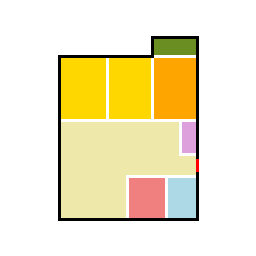

Rank 2: Image Location: /content/drive/MyDrive/tell2design/trained_floorplan_images/38759.png, Distance: 0.07837152481079102


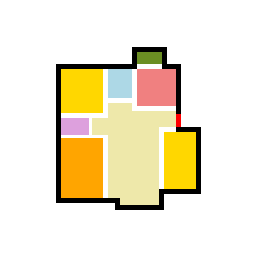

Rank 3: Image Location: /content/drive/MyDrive/tell2design/trained_floorplan_images/48868.png, Distance: 0.16867227852344513


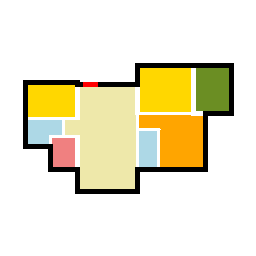

In [16]:
image_dir = '/content/drive/MyDrive/tell2design/trained_floorplan_images'

# Initialize tokenizer and model for text embeddings
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
text_model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
text_model.eval()

# Load the Faiss index
index = faiss.read_index(faiss_index_path)

# Load the metadata (mapping of Faiss indices to image paths)
# try:
    # Attempt to load as a torch dictionary (common for dictionaries saved with torch.save)
metadata = torch.load(metadata_path, map_location="cpu")
# except AttributeError:
#     # Fallback to loading as a pickle if the above fails
#     with open(metadata_path, "rb") as f:
#         metadata = pickle.load(f)

def retrieve_top_images_from_text(query_text, k=3):
    # Convert the query to a text vector
    query_embedding = query_to_embedding(query_text)

    # Search Faiss index for the closest k matching text vectors
    D, I = index.search(query_embedding.reshape(1, -1), k=k)

    for rank in range(k):
        closest_text_index = I[0][rank]  # Get the index of the current closest match
        distance = D[0][rank]  # Get the corresponding distance score

        # Retrieve the filename and construct the full path
        closest_image_filename = os.path.basename(metadata[closest_text_index])  # Only get filename
        closest_image_path = os.path.join(for_displaying_image, closest_image_filename).replace("\\", "/")
        print(f"Rank {rank + 1}: Image Location: {closest_image_path}, Distance: {distance}")

        # Load and display the image along with its score
        if os.path.exists(closest_image_path):
            image = Image.open(closest_image_path)
            display(image)  # Display the image inline
        else:
            print(f"Image not found: {closest_image_path}")

# Example usage
query = "I want a living room at the northwest corner with a balcony in the south."
query1 = "The balcony is at the north corner. near common room2 and master room. 10x6 sq ft. The bathroom is at the east and south middle of the corner. between kitchen and living room. 10x6 sq ft. Common room 1 is at the west and north middle corner. between living room and common room 2. 10x10 sq ft. Common room 2 is at the north center corner. between common room1 and master room. 10x10 sq ft. The kitchen is at the south middle  corner. between living room and bathroom. 10x8 sq ft. living room is center position. east face. 10x16 sq ft. The master room is at the north and east middle corner. between balcony and storage. 10x14 sq ft. The storage room is at the east corner. between master room and living room. 10x8 sq ft. "
q3="The bathroom is located on the east side, It is next to living and kitchen, The size of the room is 4 feet width  and 5  feet length The common room is located on the south west corner, It is next to living and master , The size of the room is 10  feet width  and 10  feet length The kitchen is located on the north east corner, It is next to living and bath, The size of the room is 7 feet width  and  8 feet length The living room is located on the north side, It is in front of all other rooms, The size of the room is 12   feet width  and  27  feet length The master room is located on the south side, It is next to living and near to common,The size of the room is 10  feet width  and  11  feet length The storage room is located on the east side,it is inside southeast corner of kitchen,The size of the room is 2  feet width  and 2  feet length "
retrieve_top_images_from_text(query1)